In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install pydub
!pip install noisereduce
!pip install json-tricks

In [ ]:
import numpy as np
import pandas as pd

import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

/usr/local/lib/python3.7/dist-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
#TESS
def emotion_T(name): 
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"
        else: return "-1"
        
        
def emotion(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # suprised

In [ ]:
def preprocess(file):
        _, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
        rawsound = AudioSegment.from_file(os.path.join(subdir,file)) 
        normalizedsound = effects.normalize(rawsound, headroom = 5.0) 
        normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
        xt, index = librosa.effects.trim(normal_x, top_db=30)
        padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant')
        final_x = nr.reduce_noise(audio_clip = padded_x, noise_clip = padded_x, verbose=False)
        return final_x,sr

In [ ]:
rms = []
zcr = []
mfcc = []
emotions = []

total_length = 173056
frame_length = 2048
hop_length = 512

folder_path = '/content/drive/MyDrive/DATASET/' 

for subdir, dirs, files in os.walk(folder_path):
  for file in files: 
      preprocessed,sr=preprocess(file)
      f1 = librosa.feature.rms(preprocessed, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square   
      f2 = librosa.feature.zero_crossing_rate(preprocessed , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR      
      f3 = librosa.feature.mfcc(preprocessed, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC
      if (emotion_T(file) != "-1"): 
            name = emotion_T(file)
      else:                             
            name = file[6:8]                       
      rms.append(f1)
      zcr.append(f2)
      mfcc.append(f3)
      emotions.append(emotion(name)) 

print("features extracted")

features extracted


In [ ]:
f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)

ZCR shape: (4232, 339, 1)
RMS shape: (4232, 339, 1)
MFCCs shape: (4232, 339, 13)


In [ ]:
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

In [ ]:
x_data = X.tolist() 
x_path = '/content/drive/My Drive/Colab Notebooks/X_datanew.json'
dump(obj = x_data, fp = x_path)

y_data = Y.tolist() 
y_path = '/content/drive/My Drive/Colab Notebooks/Y_datanew.json'
dump(obj = y_data, fp = y_path)


'[[1], [1], [1], [1], [1], [0], [1], [0], [1], [0], [0], [3], [2], [2], [3], [2], [1], [2], [2], [2], [2], [2], [3], [3], [4], [3], [4], [3], [4], [4], [3], [4], [4], [3], [4], [4], [6], [5], [5], [5], [6], [5], [5], [6], [6], [5], [5], [5], [7], [7], [7], [6], [6], [7], [7], [7], [6], [6], [7], [7], [0], [0], [0], [0], [1], [2], [2], [1], [1], [1], [2], [1], [1], [1], [2], [1], [3], [2], [3], [3], [3], [2], [3], [3], [3], [2], [2], [3], [4], [5], [5], [5], [5], [4], [4], [4], [5], [4], [5], [5], [4], [4], [4], [5], [6], [6], [6], [6], [6], [7], [7], [6], [7], [7], [7], [6], [6], [7], [7], [7], [1], [1], [0], [1], [0], [0], [1], [0], [1], [3], [3], [3], [2], [1], [2], [3], [3], [2], [2], [2], [1], [2], [3], [2], [1], [3], [3], [2], [6], [5], [6], [5], [4], [6], [4], [6], [5], [4], [5], [5], [6], [4], [4], [6], [4], [5], [6], [5], [4], [5], [4], [6], [7], [7], [7], [7], [7], [7], [7], [7], [0], [0], [0], [0], [1], [1], [2], [2], [2], [2], [1], [1], [1], [1], [2], [1], [2], [2], [3], [2]

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

y_train_class = tf.keras.utils.to_categorical(y_train, 8, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 8, dtype = 'int8')

print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(3703, 339, 15)
(368, 339, 15)
(161, 339, 15)


In [ ]:
file_path = 'x_test_data.json'
dump(obj = x_test, fp = file_path)

file_path = 'y_test_data.json'
dump(obj = y_test, fp = file_path)

'{"__ndarray__": [[7], [4], [3], [4], [3], [2], [7], [6], [6], [5], [6], [4], [4], [0], [0], [0], [4], [6], [0], [7], [7], [6], [3], [5], [4], [4], [0], [5], [6], [0], [0], [3], [1], [7], [6], [7], [4], [2], [0], [3], [2], [6], [0], [4], [0], [5], [0], [0], [4], [3], [5], [2], [5], [2], [1], [7], [3], [2], [3], [6], [2], [6], [5], [7], [6], [2], [3], [4], [4], [4], [2], [5], [3], [2], [7], [6], [7], [7], [3], [7], [3], [3], [4], [5], [7], [6], [0], [2], [6], [0], [5], [4], [7], [7], [2], [2], [6], [6], [7], [0], [6], [7], [7], [4], [0], [4], [6], [7], [4], [5], [7], [3], [2], [3], [7], [6], [7], [4], [5], [4], [7], [3], [5], [1], [6], [2], [4], [4], [4], [0], [3], [4], [3], [7], [1], [6], [5], [3], [3], [2], [1], [6], [1], [5], [4], [6], [6], [3], [5], [7], [3], [7], [3], [0], [3], [3], [4], [5], [5], [2], [6]], "dtype": "int8", "shape": [161, 1], "Corder": true}'

In [ ]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks 

In [ ]:
model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(8, activation = 'softmax'))
print(model.summary())

batch_size = 23


checkpoint_path = '/content/drive/My Drive/Colab Notebooks/best_weights.hdf5'


mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)
                             
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class, 
                      epochs=340, batch_size = batch_size, 
                      validation_data = (x_val, y_val_class), 
                      callbacks = [mcp_save, rlrop])
model.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 339, 64)           20480     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
Total params: 54,024
Trainable params: 54,024
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/340
161/161 [==============================] - 43s 247ms/step - loss: 2.0287 - categorical_accuracy: 0.1768 - val_loss: 1.9239 - val_categorical_accuracy: 0.1929
Epoch 2/340
161/161 [==============================] - 39s 244ms/step - loss: 1.8439 - categorical_accuracy: 0.2494 - val_loss: 1.8420 - val_categorical_accuracy: 0.2690
Epoch 3/340
161/161 [================

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

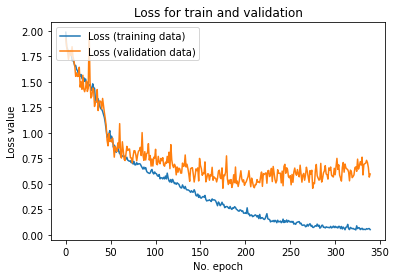

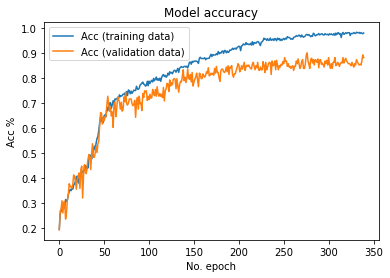

In [ ]:
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Validation score
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

12/12 - 2s - loss: 0.5088 - categorical_accuracy: 0.9022


Text(0.5, 51.0, 'Predicted emotion')

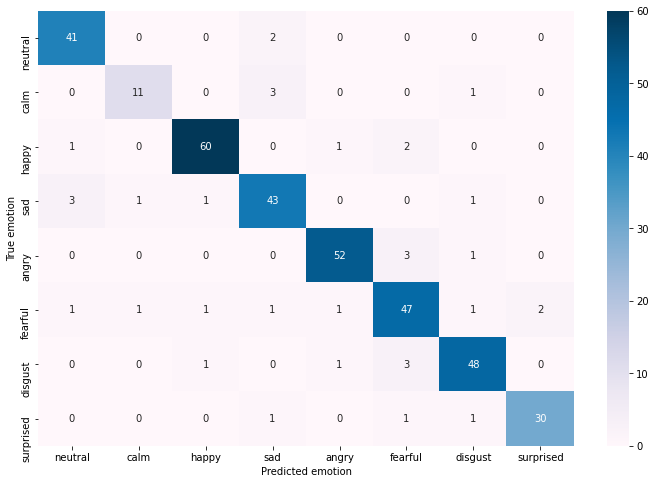

In [ ]:
# Validation Confusion matrix

y_val_class = np.argmax(y_val_class, axis=1)
predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_val_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [ ]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.9535
calm : 0.7333
happy : 0.9375
sad : 0.8776
angry : 0.9286
fearful : 0.8545
disgust : 0.9057
surprised : 0.9091


In [ ]:
# Saving model & weights

from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723_weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)
    
model.save_weights(saved_weights_path)
print("Saved model to disk")


Saved model to disk


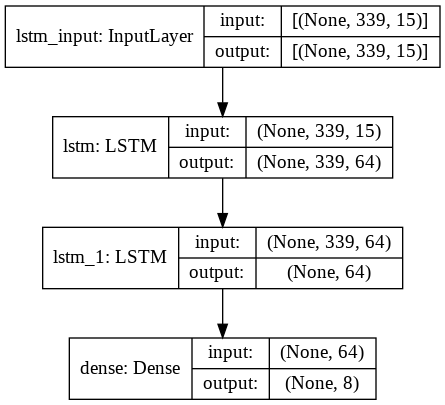

In [ ]:
# Reading the model from JSON file

saved_model_path = '/content/drive/My Drive/Colab Notebooks/model8723.json'
saved_weights_path = '/content/drive/My Drive/Colab Notebooks/model8723_weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()
    
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Loading x_test, y_test json files, and converting to np.arrays

x_test = load( 'x_test_data.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load('y_test_data.json')
y_test = np.asarray(y_test).astype('int8')

y_test_class = tf.keras.utils.to_categorical(y_test, 8, dtype = 'int8')

In [ ]:
loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

6/6 - 2s - loss: 0.6201 - categorical_accuracy: 0.8447


Text(0.5, 51.0, 'Predicted emotion')

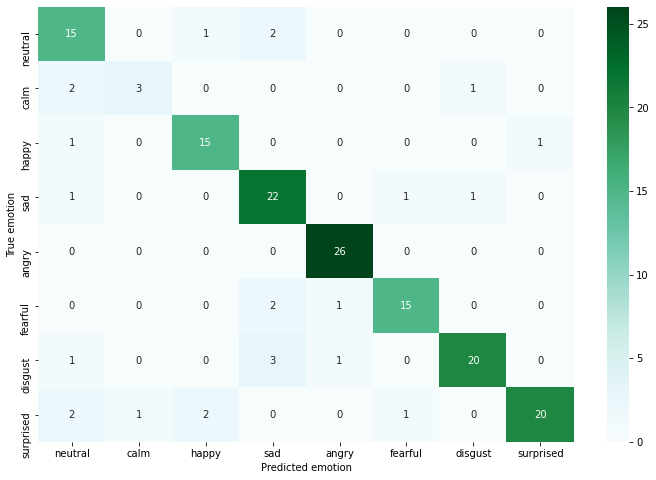

In [ ]:
# Test set Confusion matrix

y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [ ]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
neutral : 0.8333
calm : 0.5000
happy : 0.8824
sad : 0.8800
angry : 1.0000
fearful : 0.8333
disgust : 0.8000
surprised : 0.7692
